In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
import requests
import json
warnings.filterwarnings('ignore')
# import pandas_profiling
import networkx as nx
from cdlib import algorithms, viz
from collections import Counter

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'karateclub', 'wurlitzer', 'leidenalg', 'graph_tool'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'wurlitzer', 'infomap', 'leidenalg'}


## Loading and exploration of the CMU dataset

In [2]:
# load movies metadata tsv file to a pandas dataframe
movies_metadata = pd.read_csv('MovieSummaries/movie.metadata.tsv', sep='\t', header=None)
# load character metadata tsv file to a pandas dataframe
character_metadata = pd.read_csv('MovieSummaries/character.metadata.tsv', sep='\t', header=None)
# load plot summaries tsv file to a pandas dataframe
plot_summaries = pd.read_csv('MovieSummaries/plot_summaries.txt', sep='\t', header=None)

# name colomuns of movies metadata dataframe as follows 
# 1. Wikipedia movie ID
# 2. Freebase movie ID
# 3. Movie name
# 4. Movie release date
# 5. Movie box office revenue
# 6. Movie runtime
# 7. Movie languages (Freebase ID:name tuples)
# 8. Movie countries (Freebase ID:name tuples)
# 9. Movie genres (Freebase ID:name tuples)

movies_metadata.columns = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_name', 'Movie_release_date', 'Movie_box_office_revenue', 'Movie_runtime', 'Movie_languages', 'Movie_countries', 'Movie_genres'] 

# name colomuns of character metadata dataframe as follows
# 1. Wikipedia movie ID
# 2. Freebase movie ID
# 3. Movie release date
# 4. Character name
# 5. Actor date of birth
# 6. Actor gender
# 7. Actor height (in meters)
# 8. Actor ethnicity (Freebase ID)
# 9. Actor name
# 10. Actor age at movie release
# 11. Freebase character/actor map ID
# 12. Freebase character ID
# 13. Freebase actor ID

character_metadata.columns = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date', 'Character_name', 'Actor_date_of_birth', 'actor_gender', 'Actor_height_(in_meters)', 'Actor_ethnicity', 'Actor_name', 'Actor_age_at_movie_release', 'Freebase_character/actor_map_ID', 'Freebase_character_ID', 'Freebase_actor_ID']

# name colomuns of plot summaries dataframe as follows
# 1. Wikipedia movie ID
# 2. Plot summary

plot_summaries.columns = ['Wikipedia_movie_ID', 'Plot_summary']

In [3]:
character_metadata

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,actor_gender,Actor_height_(in_meters),Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


In [4]:
# # profile the movies metadata dataframe
# movies_metadata.profile_report(title='Movies Metadata Report')
# # save the report to a html file
# movies_metadata.profile_report(title='Movies Metadata Report').to_file(output_file="movies_metadata_report.html")

In [5]:
# # profile the character metadata dataframe
# character_metadata.profile_report(title='Character Metadata Report')
# # save the report to a html file
# character_metadata.profile_report(title='Character Metadata Report').to_file(output_file="character_metadata_report.html")

## cleaning the data

In [6]:
# filter characters metadata dataframe to keep only the characters where the character name and actor name are not null
characters_before_filter = character_metadata.shape[0]
character_metadata = character_metadata[character_metadata['Freebase_actor_ID'].notnull() & character_metadata['Actor_name'].notnull()]
# show how many characters were originally in the dataframe, how many were removed and how many are left
print('Number of characters before filter: ', characters_before_filter)
print('Number of characters after filter: ', character_metadata.shape[0])
print('Number of characters removed: ', characters_before_filter - character_metadata.shape[0])

Number of characters before filter:  450669
Number of characters after filter:  449441
Number of characters removed:  1228


In [7]:
# list the characters of each movie in a list and the actors of each movie in a list
actors = character_metadata.groupby('Wikipedia_movie_ID')['Actor_name'].apply(list).reset_index().rename(columns={'Actor_name': 'Actors_names'})
# count the actors of each movie
actors['Number_of_actors'] = actors['Actors_names'].apply(lambda x: len(x))
# filter the actors dataframe to keep only the movies with more than 2 actors
actors = actors[actors['Number_of_actors'] > 2].reset_index(drop=True)
# show the number of movies before and after the filter and how many movies were removed
print('Number of movies before filter: ', character_metadata['Wikipedia_movie_ID'].nunique())
print('Number of movies after filter: ', actors.shape[0])
print('Number of movies removed: ', character_metadata['Wikipedia_movie_ID'].nunique() - actors.shape[0])


Number of movies before filter:  64258
Number of movies after filter:  48770
Number of movies removed:  15488


## Further exploration of cleaned data

In [8]:
actors

,Wikipedia_movie_ID,Actors_names,Number_of_actors
0,330,"[Rosa Maria Sardà, Mercè Pons, Anna Lizaran, N...",4
1,3217,"[Ted Raimi, Ivan Raimi, Bruce Campbell, Bruce ...",14
2,3333,"[Lillian Gish, Henry B. Walthall, Mae Marsh, S...",14
3,3746,"[William Sanderson, Harrison Ford, Rutger Haue...",15
4,3837,"[Jack Starrett, Slim Pickens, Dave Sharpe, Lia...",20
...,...,...,...
48765,37322106,"[Katrina Kaif, Shahrukh Khan, Anushka Sharma]",3
48766,37373877,"[Gabrielle Anwar, Traci Lords, Dina Meyer, Geo...",7
48767,37476824,"[Zayed Khan, Raveena Tandon, Amitabh Bachchan,...",10
48768,37478048,"[Anupam Kher, Anil Kapoor, Sridevi Kapoor, Akk...",4


<AxesSubplot:xlabel='Number_of_actors', ylabel='Density'>

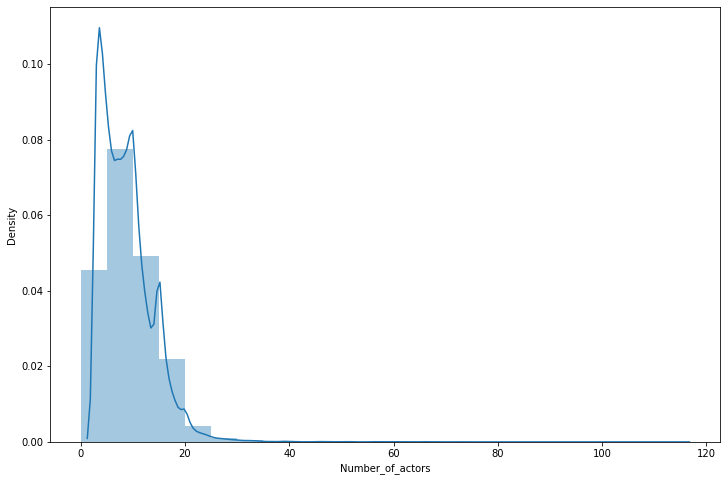

In [9]:
# plot the distribution of the number of actors per movie (histogram interval length = 5)
plt.figure(figsize=(12, 8))
sns.distplot(actors['Number_of_actors'], kde=True, bins=range(0, 120, 5))

In [10]:
# one actor per line in the new dataframe
actors_new_meta = actors.merge(character_metadata[['Character_name', 'Actor_name', 'Wikipedia_movie_ID']], on='Wikipedia_movie_ID', how='inner')

In [11]:
actors_new_meta

,Wikipedia_movie_ID,Actors_names,Number_of_actors,Character_name,Actor_name
0,330,"[Rosa Maria Sardà, Mercè Pons, Anna Lizaran, N...",4,NaN,Rosa Maria Sardà
1,330,"[Rosa Maria Sardà, Mercè Pons, Anna Lizaran, N...",4,NaN,Mercè Pons
2,330,"[Rosa Maria Sardà, Mercè Pons, Anna Lizaran, N...",4,NaN,Anna Lizaran
3,330,"[Rosa Maria Sardà, Mercè Pons, Anna Lizaran, N...",4,NaN,Núria Espert
4,3217,"[Ted Raimi, Ivan Raimi, Bruce Campbell, Bruce ...",14,S-Mart Clerk,Ted Raimi
...,...,...,...,...,...
427252,37478048,"[Anupam Kher, Anil Kapoor, Sridevi Kapoor, Akk...",4,NaN,Sridevi Kapoor
427253,37478048,"[Anupam Kher, Anil Kapoor, Sridevi Kapoor, Akk...",4,Ajay,Akkineni Nagarjuna
427254,37492363,"[Molly Cera, Taylor Marie Milton, Spencer Jenk...",3,NaN,Molly Cera
427255,37492363,"[Molly Cera, Taylor Marie Milton, Spencer Jenk...",3,NaN,Taylor Marie Milton


## Create actors Network

In [12]:
# dataframe with pairs of actors and the number of movies they acted in together
# the dataframe to merge contains all the actors_new_meta dataframe except the actors_names column
to_merge = actors_new_meta.drop('Actors_names', axis=1)
actors_pairs = to_merge.merge(to_merge, on=['Wikipedia_movie_ID', 'Number_of_actors'], how='inner')
# filter the dataframe to keep only the pairs where the actor names are different
actors_pairs = actors_pairs[actors_pairs['Actor_name_x'] != actors_pairs['Actor_name_y']]
# filter the dataframe to keep only the pairs that are not interchangeable (actor1, actor2) and (actor2, actor1)
actors_pairs = actors_pairs[actors_pairs['Actor_name_x'] < actors_pairs['Actor_name_y']]

In [13]:
# for each pair make a new column with the list of movies they acted in together
actors_pairs_common_movies = actors_pairs.groupby(['Actor_name_x', 'Actor_name_y'])['Wikipedia_movie_ID'].apply(list).reset_index().rename(columns={'Wikipedia_movie_ID': 'Common_movies'})
# remove the duplicates in the movies list
actors_pairs_common_movies['Common_movies'] = actors_pairs_common_movies['Common_movies'].apply(lambda x: list(set(x)))

In [14]:
# number of common movies between each pair of actors
actors_pairs_common_movies['Number_of_common_movies'] = actors_pairs_common_movies['Common_movies'].apply(lambda x: len(x))

In [15]:
# filter the dataframe to keep only the pairs that acted in more than 3 movies together
actors_pairs_common_movies_filtered = actors_pairs_common_movies[actors_pairs_common_movies['Number_of_common_movies'] > 2]

In [16]:
actors_pairs_common_movies_filtered

,Actor_name_x,Actor_name_y,Common_movies,Number_of_common_movies
242,50 Cent,Ambyr Childers,"[24150888, 31738289, 33638321]",3
293,50 Cent,Dr. Dre,"[25010699, 6501095, 3914063]",3
439,50 Cent,Val Kilmer,"[27211939, 19547540, 30244564]",3
1418,A. Michael Baldwin,Angus Scrimm,"[1802400, 3305282, 3305261, 12213358]",4
1419,A. Michael Baldwin,Bill Thornbury,"[1802400, 3305282, 3305261]",3
...,...,...,...,...
2070255,Yuko Kobayashi,高田由美,"[5396840, 5397050, 4174679]",3
2070256,Yuko Miyamura,Yuriko Yamaguchi,"[2017072, 1714278, 13165463]",3
2070323,Yuri Amano,Yūko Mizutani,"[5396840, 5397050, 4174679]",3
2070324,Yuri Amano,高田由美,"[5396840, 5397050, 4174679]",3


In [17]:
# create a non directed graph from the dataframe
G = nx.from_pandas_edgelist(actors_pairs_common_movies_filtered, source='Actor_name_x', target='Actor_name_y', edge_attr='Number_of_common_movies')
# show the number of nodes and edges in the graph
print('Number of nodes: ', G.number_of_nodes())
print('Number of edges: ', G.number_of_edges())

Number of nodes:  8415
Number of edges:  25898


In [18]:
# make partitions of the graph 
coms = algorithms.louvain(G, weight='Number_of_common_movies', randomize=False)
subgraphs = [G.subgraph(c) for c in coms.communities]
# show the number of subgraphs
print('Number of communities: ', len(subgraphs))
# show the number of nodes in each subgraph and the average weight of the edges in each subgraph
for i, subgraph in enumerate(subgraphs):
    print('community ', i + 1, ' number of actors: ', subgraph.number_of_nodes())
    print('community ', i + 1, ' average numbers of movies between actors: ', subgraph.size(weight='Number_of_common_movies') / subgraph.number_of_edges())

Number of communities:  638
community  1  number of actors:  983
community  1  average numbers of movies between actors:  3.6685655100983947
community  2  number of actors:  719
community  2  average numbers of movies between actors:  4.475798737325426
community  3  number of actors:  569
community  3  average numbers of movies between actors:  4.297604035308954
community  4  number of actors:  567
community  4  average numbers of movies between actors:  3.7243285939968405
community  5  number of actors:  460
community  5  average numbers of movies between actors:  3.489821882951654
community  6  number of actors:  363
community  6  average numbers of movies between actors:  4.9363327674023765
community  7  number of actors:  334
community  7  average numbers of movies between actors:  3.4701030927835053
community  8  number of actors:  313
community  8  average numbers of movies between actors:  3.69364161849711
community  9  number of actors:  274
community  9  average numbers of mov

community  293  number of actors:  2
community  293  average numbers of movies between actors:  4.0
community  294  number of actors:  2
community  294  average numbers of movies between actors:  3.0
community  295  number of actors:  2
community  295  average numbers of movies between actors:  3.0
community  296  number of actors:  2
community  296  average numbers of movies between actors:  3.0
community  297  number of actors:  2
community  297  average numbers of movies between actors:  3.0
community  298  number of actors:  2
community  298  average numbers of movies between actors:  3.0
community  299  number of actors:  2
community  299  average numbers of movies between actors:  3.0
community  300  number of actors:  2
community  300  average numbers of movies between actors:  3.0
community  301  number of actors:  2
community  301  average numbers of movies between actors:  9.0
community  302  number of actors:  2
community  302  average numbers of movies between actors:  3.0


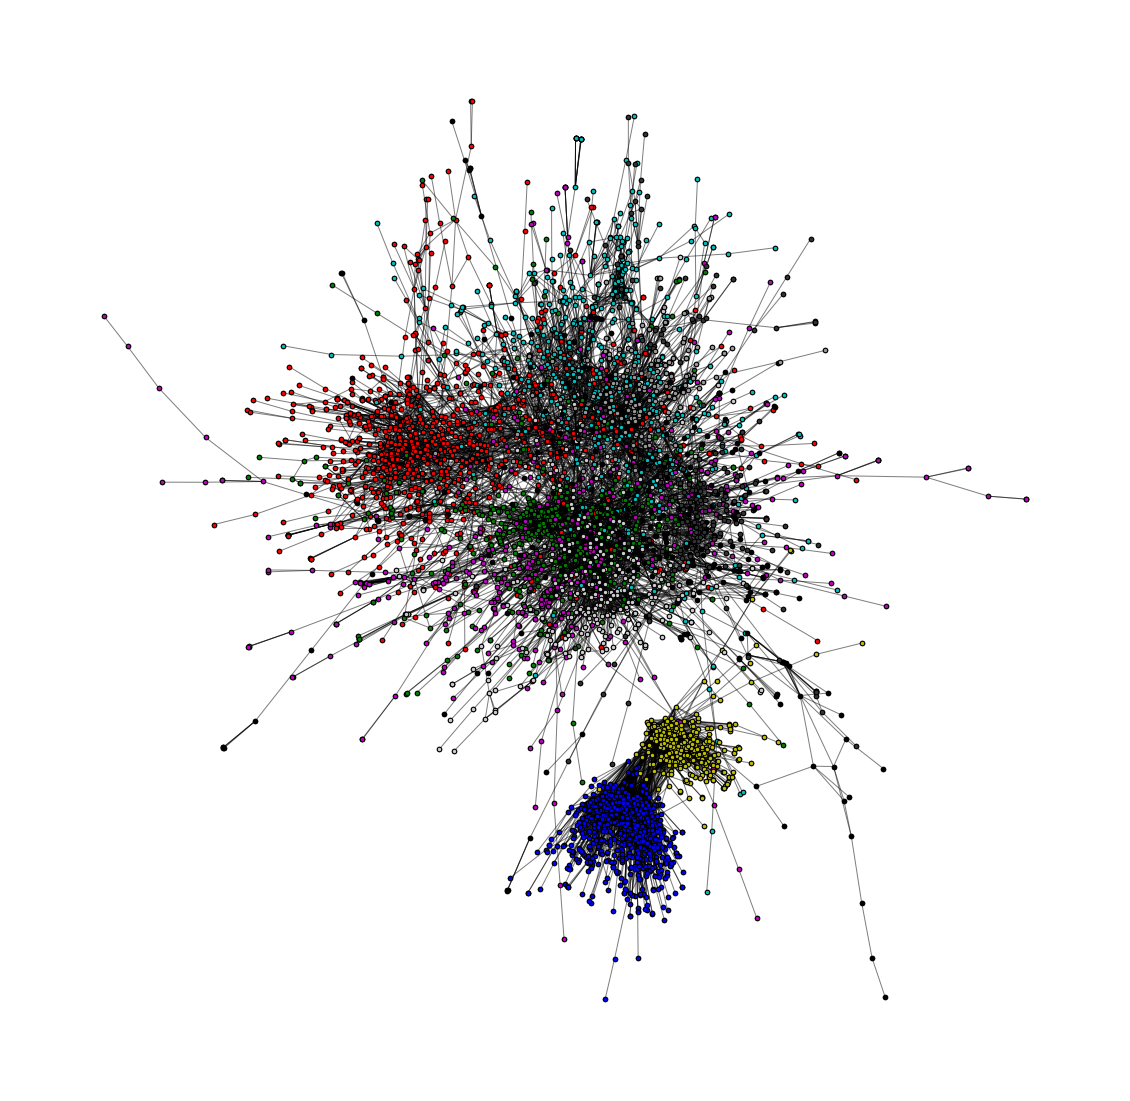

In [19]:
# vizualise the obtained partitions (top 10 communities)
from cdlib import viz
viz.plot_network_clusters(G, coms, node_size=20, figsize=(20, 20), plot_labels=False, top_k=10)

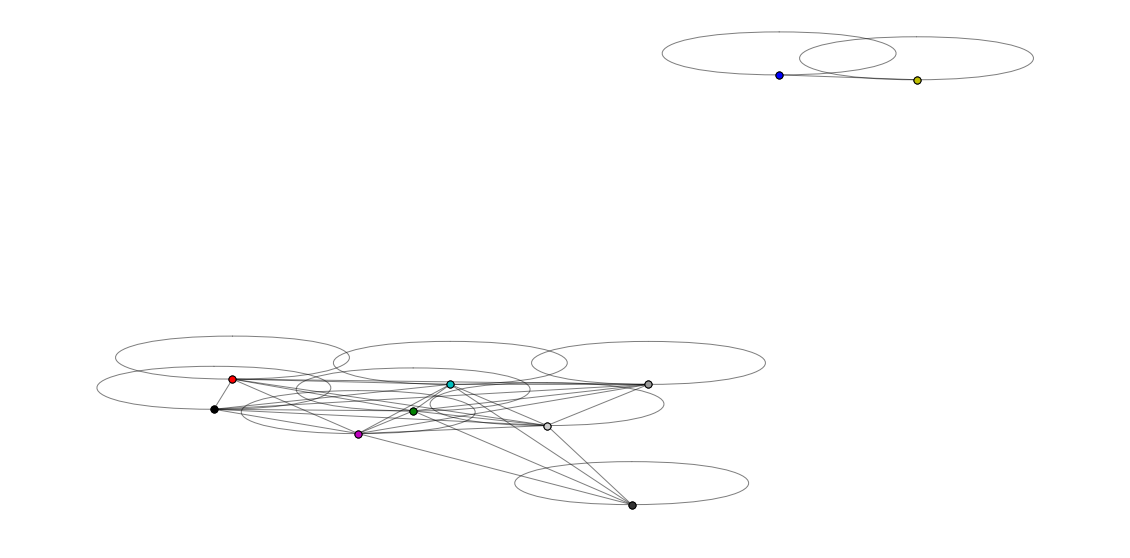

In [20]:
# vizualise the obtained partitions (all communities)
viz.plot_community_graph(G, coms, node_size=50, figsize=(20, 10), plot_labels=False, top_k=10)

In [21]:
# store the top 20 communities in dataframes
# each row in the dataframe is an actor in the community, the connectivity column represents the total weight of the edges that the actor is connected to
# i.e the total number of movies the actor acted in with the other actors in the community
top_20_communities = []
for i, subgraph in enumerate(subgraphs[:20]):
    top_20_communities.append(pd.DataFrame(subgraph.degree(weight='Number_of_common_movies'), columns=['Actor_name', 'connectivity']).sort_values('connectivity', ascending=False))

In [22]:
# for each community add columns for actors ethnicity, gender and date of birth from the character_metadata dataframe
for i, community in enumerate(top_20_communities):
    top_20_communities[i] = community.merge(character_metadata[['Actor_name','actor_gender', 'Actor_date_of_birth', 'Actor_ethnicity', 'Freebase_actor_ID']], on='Actor_name', how='inner').drop_duplicates(subset=['Actor_name']).reset_index(drop=True)
    top_20_communities[i]['community'] = i + 1


In [23]:
# make a dataframe that contains all actors from top 20 community, add a column for the community number(1-20)
top_20_communities_all_actors = pd.concat(top_20_communities).reset_index(drop=True)


In [24]:
top_20_communities_all_actors
# save to csv
# top_20_communities_all_actors.to_csv('top_20_communities_all_actors.csv', index=False)

,Actor_name,connectivity,actor_gender,Actor_date_of_birth,Actor_ethnicity,Freebase_actor_ID,community
0,John Wayne,286,M,1907-05-26,/m/063k3h,/m/043gj,1
1,Roy Rogers,242,M,1911-11-05,/m/07hwkr,/m/01mc6h1,1
2,George 'Gabby' Hayes,130,M,1885-05-07,NaN,/m/03l6jx,1
3,Basil Rathbone,121,M,1892-06-13,NaN,/m/0hwd8,1
4,John Carradine,114,M,1906-02-05,NaN,/m/021mlp,1
...,...,...,...,...,...,...,...
6069,Jayanthi,3,F,1945-10-11,/m/0dryh9k,/m/0fd1cb,20
6070,Sarathi,3,M,1942-06-26,NaN,/m/0463_8t,20
6071,Vijayakumari,3,F,NaN,/m/0dryh9k,/m/0gc49tb,20
6072,Ragini,3,F,1937,NaN,/m/06w4wmq,20


In [25]:
# profile the obtained dataframe
# profile = pandas_profiling.ProfileReport(top_20_communities_all_actors)
# profile.to_file("top_20_communities_all_actors.html")


In [26]:
# load actor dataframe after scraping
actors_scraping = pd.read_csv('top_20_communities_all_actors_wikidata_with_country_occupation.csv')
actors_scraping

,Actor_name,connectivity,actor_gender,Actor_date_of_birth,Actor_ethnicity,Freebase_actor_ID,community,Wikidata_actor_id,actor_description,actor_country_of_citizenship,actor_occupation
0,John Wayne,286,M,1907-05-26,/m/063k3h,/m/043gj,1,Q40531,American actor (1907–1979),United States of America,"['actor', 'film actor', 'film director', 'film..."
1,Roy Rogers,242,M,1911-11-05,/m/07hwkr,/m/01mc6h1,1,Q367129,American actor and singer (1911-1998),United States of America,"['television actor', 'film actor', 'singer', '..."
2,George 'Gabby' Hayes,130,M,1885-05-07,NaN,/m/03l6jx,1,Q1277973,American actor (1885-1969),United States of America,"['actor', 'television actor', 'film actor', 'r..."
3,Basil Rathbone,121,M,1892-06-13,NaN,/m/0hwd8,1,Q336865,English actor (1892–1967),United Kingdom,"['character actor', 'stage actor', 'film actor..."
4,John Carradine,114,M,1906-02-05,NaN,/m/021mlp,1,Q312878,American actor (1906-1988),United States of America,"['film actor', 'character actor', 'stage actor..."
...,...,...,...,...,...,...,...,...,...,...,...
6069,Pushpavalli,3,F,NaN,NaN,/m/080hxfv,20,Q7261853,Indian actress,India,['actor']
6070,Sarathi,3,M,1942-06-26,NaN,/m/0463_8t,20,Q7423331,Indian actor,India,['actor']
6071,Ragini,3,F,1937,NaN,/m/06w4wmq,20,Q7283094,Indian actress,India,['actor']
6072,Nirmalamma,3,F,1920,NaN,/m/07kj3f9,20,Q7040057,Indian actress,India,['actor']


Occupation preprocessing

In [27]:
# 
list_occupations=list(actors_scraping['actor_occupation'])
# Function that extracts occupations from string of occupations
def extract_occupation(string):
    occupation_list=""
    if isinstance(string,str):
        string=string.replace("'", "")
        string=string.replace("[", "")
        string=string.replace("]", "")
        occupation_list = string.split(",")
    
    return occupation_list
occupations_with_dupilicate=[]
for s in list_occupations:
    split_string=extract_occupation(s)
    split_string = [x.strip() for x in split_string]
    occupations_with_dupilicate.append(split_string)
occupations_with_dupilicate

[['actor',
  'film actor',
  'film director',
  'film producer',
  'screenwriter',
  'American football player',
  'television actor'],
 ['television actor',
  'film actor',
  'singer',
  'actor',
  'musician',
  'yodeler',
  'songwriter',
  'film producer'],
 ['actor', 'television actor', 'film actor', 'radio personality'],
 ['character actor', 'stage actor', 'film actor', 'television actor'],
 ['film actor',
  'character actor',
  'stage actor',
  'television actor',
  'voice actor',
  'painter',
  'sculptor'],
 ['television actor',
  'film actor',
  'military officer',
  'aircraft pilot',
  'character actor',
  'television director',
  'screenwriter',
  'military personnel',
  'stage actor',
  'poet',
  'voice actor',
  'film director'],
 ['film actor', 'actor', 'character actor', 'stage actor', 'film director'],
 ['film director',
  'composer',
  'musician',
  'screenwriter',
  'stage actor',
  'film actor',
  'actor',
  'television presenter'],
 [''],
 ['singer',
  'novelist',
  '

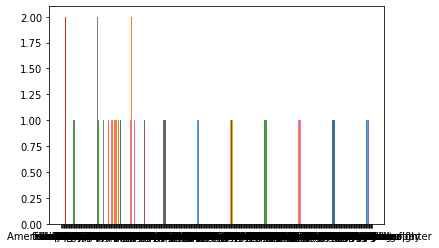

In [28]:
# occupations_unique =  Counter({x for x in occupations_with_dupilicate for x in l})
occupations_unique =  Counter([item for sublist in occupations_with_dupilicate for item in sublist])
plt.hist(occupations_unique.items())
plt.show()

Features distribution in communities

In [46]:
# df_feature_distribution=actors_scraping.groupby(['community'])
# df_feature_distribution.apply(lambda x: x) 
df_feature_distribution = pd.DataFrame(columns=['Community','Males','Females','1st_country','2nd_country','3rd_country','1st_occupation','2nd_occupation','3rd_occupation'])
for i in range(1, 20):
    df=actors_scraping[actors_scraping['community']==i]
    gender_distribution=df['actor_gender'].value_counts(normalize=True) * 100
    country_distribution=df['actor_country_of_citizenship'].value_counts(normalize=True)
    print("Community",i,":")
    print("Males=",gender_distribution.M,"%,Females=",gender_distribution.F)
    print(country_distribution[:3].to_string())
df_feature_distribution

Community 1 :
Males= 67.68916155419224 %,Females= 32.31083844580777
United States of America    0.801036
United Kingdom              0.093264
Canada                      0.033161
Community 2 :
Males= 59.33147632311978 %,Females= 40.66852367688023
India             0.933657
British Raj       0.035599
United Kingdom    0.012945
Community 3 :
Males= 67.31107205623901 %,Females= 32.68892794376098
United States of America    0.900722
Canada                      0.041516
United Kingdom              0.032491
Community 4 :
Males= 71.90812720848056 %,Females= 28.091872791519435
United Kingdom              0.600713
United States of America    0.169340
Australia                   0.074866
Community 5 :
Males= 71.30434782608695 %,Females= 28.695652173913043
United States of America    0.761062
United Kingdom              0.059735
Canada                      0.042035
Community 6 :
Males= 66.01671309192201 %,Females= 33.98328690807799
India     0.987915
Egypt     0.003021
Bhutan    0.003021
Communit

,Community,Males,Females,1st_country,2nd_country,3rd_country,1st_occupation,2nd_occupation,3rd_occupation
